# Quantum Approximation Optimization Algorithm (QAOA) for Not-all-equal 3-satisfiability (NAE3SAT)

## Overview

Quantum Approximation Optimization Algorithm (QAOA) is a hybrid classical-quantum algorithm used for solving the combinatorial optimization problem, which is proposed by [Farhi, Goldstone, and Gutmann (2014)](https://arxiv.org/abs/1411.4028). In QAOA, the parameterized quantum circuit is regarded as an oracle, we sample the circuit to obtain the gradient of the parameters, and update them through the classical optimizer. Before this tutorial, there was already a tutorial of [QAOA for Max-Cut](qaoa.ipynb). In this tutorial, we will focus on another combinatorial optimization problem - Not-all-equal 3-satisfiability (NAE3SAT), and discuss the performance of QAOA in different hardness cases.


## Not-all-equal 3-satisfiability (NAE3SAT)

[Not-all-equal 3-satisfiability (NAE3SAT)](https://en.wikipedia.org/wiki/Not-all-equal_3-satisfiability) is a variant of 3-satisfiability (3-SAT) and 3-SAT is a subset of [Boolean satisfiability problem (SAT)](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem). SAT is, given a Boolean expression, to check whether it is satisfiable, where the Boolean expression is a disjunction of clauses (or a single clause) and each clause is a disjunction of literals (or a single literal). Here is an example of Boolean expression of SAT,
$$
\begin{equation}
    (x_1\lor x_2\lor\cdots\lor x_m)\land(\lnot x_5\lor x_9\lor\cdots\lor x_m)\land\cdots\land(x_m\lor \lnot x_{m+3}\lor\cdots\lor \lnot x_n),
\end{equation}
$$
where $(x_i\lor x_j\lor\cdots\lor x_k)$ is a clause and $x_i$ is a literal. SAT with $k$ literals in each clause is called $k$-SAT, thus in 3-SAT, there are only three literals in each clause, for example
$$
\begin{equation}
    (x_1\lor x_2\lor x_m)\land(\lnot x_5\lor x_9\lor x_m)\land\cdots\land(x_m\lor \lnot x_{m+3}\lor \lnot x_n).
\end{equation}
$$
When $k$ is not less than 3, SAT is NP-complete. On the other hand, NAE3SAT requires the three literals in each clause are not all equal to each other, in other words, at least one is true, and at least one is false. It is different from 3-SAT, which requires at least one literal is true in each clause. However, NAE3SAT is still NP-complete, [which can be proven by a reduction from 3-SAT](https://en.wikipedia.org/wiki/Not-all-equal_3-satisfiability).


Now we use the spin model to represent a NAE3SAT. Let the set of clauses in the NAE3SAT be $\mathcal{C}$. In each clause, there are three literals and each literal is represented by a spin. Spins up ($s=1$, $\text{bit}=0$) and down ($s=-1$, $\text{bit}=1$) represent false and true respectively. For the clause $(s_i,\ s_j,\ s_k)\in\mathcal{C}$, $s_i,\ s_j,\ s_k$ cannot be 1 or -1 at the same time. The Hamiltonian of the NAE3SAT is as follows
$$
\begin{equation}
    \begin{split}
        \hat{H}_C&=\sum_{(i,j,k)\in\mathcal{C}}\left[(s_i+s_j+s_k)^2-1\right]/2\\
        &=\sum_{(i,j,k)\in\mathcal{C}}(s_i s_j+s_j s_k+s_k s_i)+|\mathcal{C}|,
    \end{split}
\end{equation}
$$
where $|\mathcal{C}|$ is the number of clauses in $\mathcal{C}$. When all clauses are true, $\hat{H}_C$ takes the minimum value 0, and the corresponding bit string is the solution of the NAE3SAT.

## QAOA for NAE3SAT

QAOA utilizes a parameterized quantum circuit ([PQC](https://tensorcircuit.readthedocs.io/en/latest/textbook/chap5.html?highlight=变分)) to generate a quantum state that represents a potential solution. The initial state, denoted as $|s\rangle$, is a uniform superposition over computational basis states.
$$
\begin{equation}
    |s\rangle=\frac{1}{\sqrt{2^n}}\sum_z|z\rangle
\end{equation}
$$
This state is then evolved by a unitary operator that consists of $p$ layers, denoted as
$$
\begin{equation}
    U(\boldsymbol{\beta}, \boldsymbol{\gamma}) = V_{p}U_{p} \cdots V_{1}U_{1},
\end{equation}
$$
where $U_{j}= e^{-i\gamma_{j}\hat{H}_{C}}$ is the driving layer and $V_{j}= e^{-i \beta_{j} \hat{H}_m}$ is the mixing layer. $H_C$ is the driving and cost Hamiltonian introduced in previous section and the mixing Hamiltonian $\hat{H}_m=\sum_{j=1}^{n}\sigma_j^x$ is used to mix the quantum state to explore different solutions. The unitary operator is parameterized by $2p$ angle parameters $\gamma_1, \gamma_2,  \dots, \gamma_p$ and $\beta_1, \beta_2, \dots ,\beta_p$ and each $\gamma$ and $\beta$ are restricted to lie between $0$ and $2\pi$.

Begin with a set of initial $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$, the quantum state is obtained from the PQC and then the expectation value of $H_C$ is calculated. A classical optimizer is then used to vary the parameters until a lower expectation value is found. This process is iterated a certain number of times until the expectation value of $H_C$ is approximated to 0. Then we perform projective measurement on the quantum state output by PQC, and obtain a bit string, which is very likely to be the solution of NAE3SAT. Since NAE3SAT is an NP-complete problem, we can verify whether the solution is correct in polynomial time on classical computer. Even if this bit string is not the correct solution, we can repeat the projective measurement and verify the obtained solution until we get the correct solution.

For other details of QAOA, such as the selection of $p$ and the overall algorithm loop, please refer to [Farhi, Goldstone, and Gutmann (2014)](https://arxiv.org/abs/1411.4028) or the tutorial of [QAOA for Max-Cut](qaoa.ipynb).

### The code

In [5]:
import tensorcircuit as tc
import optax
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import random

K = tc.set_backend('jax')

nlayers = 30  # the number of layers
ncircuits = 6  # six circuits with different initial parameters are going to be optimized at the same time

#### Define the Graph

The graph of NAE3SAT is constructed by the set $\mathcal{C}$ of clauses. When a clause is violated, the energy will increase by 4, so the upper bound of $\hat{H}_C$ will not exceed $4|\mathcal{C}|$. In practice, we multiply $\hat{H}_C$ by a normalization factor $1/(4|\mathcal{C}|)$.

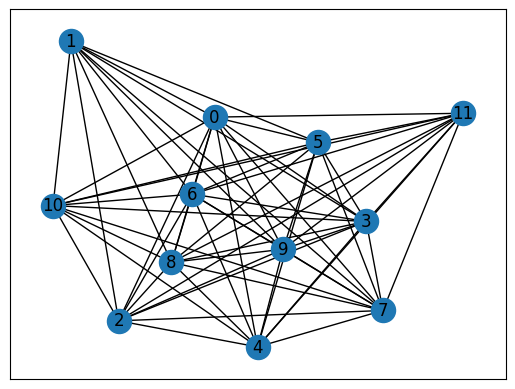

In [6]:
# a easy graph instance
easy_clauses = [[4, 7, 6], [0, 5, 9], [2, 6, 9], [2, 6, 7], [3, 1, 9], [5, 9, 11], [4, 8, 9], [5, 1, 9], [3, 8, 6], [2, 8, 10], [5, 6, 8], [2, 9, 6], [2, 6, 8], [5, 3, 9], [4, 11, 7], [3, 11, 10], [5, 10, 7], [3, 9, 8], [3, 6, 9], [2, 4, 7], [4, 0, 6], [3, 4, 6], [3, 11, 6], [4, 5, 6], [4, 0, 10], [5, 4, 10], [3, 7, 9], [0, 11, 6], [5, 11, 9], [3, 5, 9], [3, 4, 7], [3, 4, 7], [3, 0, 7], [1, 7, 8], [0, 3, 10], [0, 8, 9], [5, 7, 8], [2, 9, 6], [0, 8, 6], [4, 6, 8], [3, 2, 9], [4, 3, 8], [0, 2, 8], [4, 5, 10], [2, 4, 8], [5, 8, 9], [4, 8, 9], [3, 5, 11], [5, 4, 10], [2, 7, 9], [3, 0, 7], [2, 8, 6], [5, 3, 6], [0, 6, 10], [3, 2, 8], [4, 6, 9], [3, 2, 6], [1, 5, 6], [2, 8, 11], [2, 10, 8], [2, 0, 6], [2, 6, 9], [0, 8, 7], [0, 10, 8], [3, 5, 7], [2, 10, 8], [5, 7, 9], [0, 1, 6], [0, 3, 8], [0, 6, 9], [0, 5, 11], [1, 2, 10]]
factor = 1 / len(easy_clauses) / 4

# convert to a NetworkX graph
easy_graph = nx.Graph()
for i, j, k in easy_clauses:
    easy_graph.add_edge(i, j, weight=0)
    easy_graph.add_edge(j, k, weight=0)
    easy_graph.add_edge(k, i, weight=0)
for i, j, k in easy_clauses:
    easy_graph[i][j]['weight'] += 1
    easy_graph[j][k]['weight'] += 1
    easy_graph[k][i]['weight'] += 1
pos_easy = nx.spring_layout(easy_graph)
nx.draw_networkx(easy_graph, with_labels=True, pos=pos_easy)
ax = plt.gca()
ax.set_facecolor('w')

#### Parameterized Quantum Circuit (PQC)

In [7]:
def QAOAansatz(params, g, each=1, return_circuit=False):
    n = g.number_of_nodes()  # the number of nodes

    # PQC loop
    def pqc_loop(s_, params_):
        c_ = tc.Circuit(n, inputs=s_)
        for j in range(each):
            # driving layer
            for a, b in g.edges:
                c_.RZZ(a, b, theta=g[a][b]['weight'] * params_[2 * j] * factor)
            # mixing layer
            for i in range(n):
                c_.RX(i, theta=params_[2 * j + 1])
        s_ = c_.state()
        return s_

    c0 = tc.Circuit(n)
    for i in range(n):
        c0.H(i)
    s0 = c0.state()
    s = K.scan(pqc_loop, K.reshape(params, [nlayers // each, 2 * each]), s0)
    c = tc.Circuit(n, inputs=s)

    # whether to return the circuit
    if return_circuit is True:
        return c

    # calculate the loss function
    loss = 0.25
    for a, b in g.edges:
        loss += c.expectation_ps(z=[a, b]) * g[a][b]['weight'] * factor

    return K.real(loss)

#### Optimization

Here, several circuits with different initial parameters are optimized/trained at the same time.

Optimizers are used to find the minimum value.

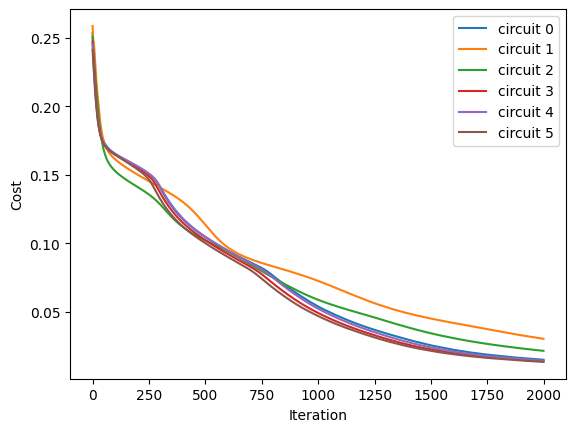

In [8]:
# use vvag to get the losses and gradients with different random circuit instances
QAOA_vvag = K.jit(K.vvag(QAOAansatz, argnums=0, vectorized_argnums=0), static_argnums=(1, 2, 3))

params_easy = K.implicit_randn(shape=[ncircuits, 2 * nlayers], stddev=0.1)  # initial parameters
if type(K).__name__ == 'JaxBackend':
    opt = K.optimizer(optax.adam(1e-2))
else:
    opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

list_of_loss = [[] for i in range(ncircuits)]

for i in range(2000):
    loss, grads = QAOA_vvag(params_easy, easy_graph)
    params_easy = opt.update(grads, params_easy)  # gradient descent

    # visualise the progress
    clear_output(wait=True)
    list_of_loss = np.hstack((list_of_loss, K.numpy(loss)[:, np.newaxis]))
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    for index in range(ncircuits):
        plt.plot(range(i + 1), list_of_loss[index])
    legend = [f'circuit {leg}' for leg in range(ncircuits)]
    plt.legend(legend)
    plt.show()

#### Results

After inputting the optimized parameters back to the ansatz circuit, we can perform the projective measurement on the output quantum state to get the solution. Here we directly use the bit string with the maximum probability as the solution since we know all information of the probability distribution of the output quantum state, but which is not feasible in the experiment.

In [9]:
# print QAOA results
for num_circuit in range(ncircuits):
    print(f'Circuit #{num_circuit}')
    c = QAOAansatz(params=params_easy[num_circuit], g=easy_graph, return_circuit=True)
    loss = QAOAansatz(params=params_easy[num_circuit], g=easy_graph)

    # find the states with max probabilities
    probs = K.numpy(c.probability())
    max_prob = max(probs)
    index = np.where(probs == max_prob)[0]
    states = []
    for i in index:
        states.append(f'{bin(i)[2:]:0>{c._nqubits}}')

    print(f'cost: {K.numpy(loss)}\nmax prob: {max_prob}\nbit strings: {states}\n')

Circuit #0
cost: 0.014918745495378971
max prob: 0.2869008183479309
bit strings: ['111111000000']

Circuit #1
cost: 0.030193958431482315
max prob: 0.21499991416931152
bit strings: ['111111000000']

Circuit #2
cost: 0.021412445232272148
max prob: 0.24743150174617767
bit strings: ['000000111111']

Circuit #3
cost: 0.013799840584397316
max prob: 0.2941778600215912
bit strings: ['000000111111']

Circuit #4
cost: 0.014260157942771912
max prob: 0.29104718565940857
bit strings: ['111111000000']

Circuit #5
cost: 0.013322753831744194
max prob: 0.2968374788761139
bit strings: ['111111000000']



## Classical Method

Here we use two classical methods. The first is the brutal force method (BF), which is to check all bit string one-by-one and need exponential time, thus the obtained solution is guaranteed to be correct.

In [10]:
def b2s(bit):
    return 1 - 2 * int(bit)

def energy(cfg, graph, normalize=True):
    E = 0.25
    for a, b in graph.edges:
        E += cfg[a] * cfg[b] * graph[a][b]['weight'] * factor
    return E if normalize else E / factor

def brutal_force(graph):
    num_nodes = graph.number_of_nodes()
    min_cost, best_case = 1., []
    for i in range(2 ** num_nodes):
        case = f'{bin(i)[2:]:0>{num_nodes}}'

        cost = energy(list(map(b2s, case)), graph)

        gap = min_cost - cost
        if gap > 1e-6:
            min_cost = cost
            best_case = [case]
        elif abs(gap) < 1e-6:
            best_case.append(case)

    return best_case, min_cost

cost: 0.000
bit string: ['000000111111', '111111000000']


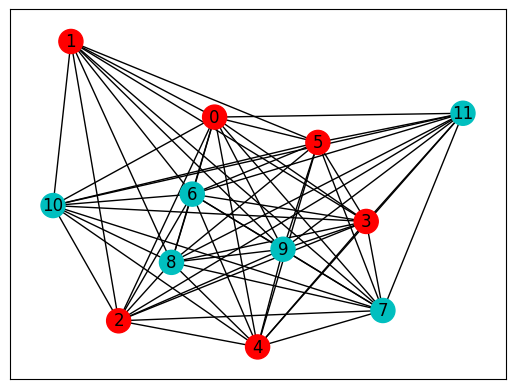

In [11]:
# print BF results
bf_best_cases, bf_best = brutal_force(easy_graph)
print(f'cost: {bf_best:.3f}\nbit string: {bf_best_cases}')

# plot NetworkX graph
colors = ['r' if bf_best_cases[0][i] == '0' else 'c' for i in easy_graph.nodes]
nx.draw_networkx(easy_graph, with_labels=True, node_color=colors, pos=pos_easy)
ax = plt.gca()
ax.set_facecolor('w')

Another method is the simulated annealing method (SA), which is an approximation method that can be done in polynomial time, so the obtained solution has only a certain probability of being correct.

In [12]:
def sim_annealing(graph, t_max: int, T: float):
    num_nodes = graph.number_of_nodes()
    state = np.random.randint(0, 2, num_nodes)
    next_state = state.copy()
    E = energy(1 - 2 * state, graph, normalize=False)
    t = 0
    while t < t_max:
        temper = (1 - t / t_max) * T
        flip_idx = np.random.randint(num_nodes)
        next_state[flip_idx] = 1 - next_state[flip_idx]
        next_E = energy(1 - 2 * next_state, graph, normalize=False)
        if next_E <= E or np.exp(-(next_E - E) / temper) > np.random.rand():
            state[flip_idx] = 1 - state[flip_idx]
            E = next_E
        else:
            next_state[flip_idx] = 1 - next_state[flip_idx]
        t += 1
    return ''.join(map(str, state.tolist())), E

In [13]:
# print SA results
sa_best_cases, sa_best, n_exp = [], float('inf'), 100
for _ in range(n_exp):
    sa_case, sa_cost = sim_annealing(easy_graph, 200, 1)
    gap = sa_best - sa_cost
    if gap > 1e-6:
        sa_best = sa_cost
        sa_best_cases = [sa_case]
    elif abs(gap) < 1e-6:
        sa_best_cases.append(sa_case)
sa_prob = len(sa_best_cases) / n_exp
sa_best_cases = list(set(sa_best_cases))
print(f'cost: {sa_best:.3f}\nprob: {sa_prob:.3f}\nbit string: {sa_best_cases}')

cost: 0.000
prob: 0.910
bit string: ['000000111111', '111111000000']


## Hard Problem

We call the above problem an easy problem, because the classical simulated annealing method has a high probability to obtain the correct solution. Now let's define another relatively hard problem.

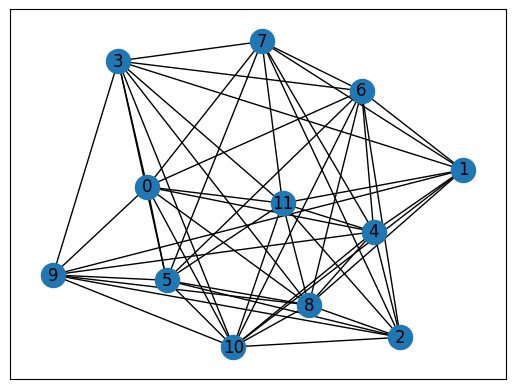

In [14]:
# a hard graph instance
hard_clauses = [[4, 1, 7], [5, 11, 8], [4, 1, 8], [4, 11, 8], [4, 1, 10], [5, 11, 8], [4, 1, 8], [1, 11, 8], [4, 1, 7], [0, 11, 8], [4, 1, 10], [4, 11, 8], [5, 0, 10], [0, 6, 7], [5, 0, 11], [0, 6, 7], [5, 0, 9], [3, 6, 7], [5, 0, 8], [5, 6, 7], [5, 0, 10], [3, 6, 7], [5, 0, 10], [1, 6, 7], [2, 4, 6], [1, 8, 11], [2, 4, 6], [2, 8, 11], [2, 4, 9], [5, 8, 11], [2, 4, 10], [2, 8, 11], [2, 4, 10], [4, 8, 11], [2, 4, 8], [4, 8, 11], [3, 0, 9], [5, 11, 7], [3, 0, 10], [2, 11, 7], [3, 0, 9], [0, 11, 7], [3, 0, 9], [5, 11, 7], [3, 0, 10], [3, 11, 7], [3, 0, 7], [4, 11, 7], [5, 0, 10], [4, 0, 10], [2, 5, 6], [2, 11, 10], [2, 6, 10], [2, 4, 9], [0, 9, 10], [3, 0, 7], [2, 5, 6], [1, 10, 9], [1, 4, 11], [5, 10, 11], [0, 4, 8], [0, 9, 8], [2, 11, 10], [2, 8, 6], [3, 6, 7], [0, 8, 10], [4, 0, 9], [3, 5, 8], [5, 11, 10], [2, 11, 10], [4, 11, 8], [1, 3, 11]]
factor = 1 / len(hard_clauses) / 4

# convert to a NetworkX graph
hard_graph = nx.Graph()
for i, j, k in hard_clauses:
    hard_graph.add_edge(i, j, weight=0)
    hard_graph.add_edge(j, k, weight=0)
    hard_graph.add_edge(k, i, weight=0)
for i, j, k in hard_clauses:
    hard_graph[i][j]['weight'] += 1
    hard_graph[j][k]['weight'] += 1
    hard_graph[k][i]['weight'] += 1
pos_hard = nx.spring_layout(hard_graph)
nx.draw_networkx(hard_graph, with_labels=True, pos=pos_hard)
ax = plt.gca()
ax.set_facecolor('w')

We first solve this problem by two classical methods.

cost: 0.000
bit string: ['000000111111', '111111000000']


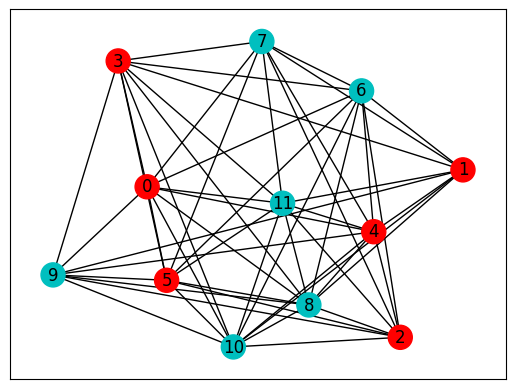

In [15]:
# print BF results
bf_best_cases, bf_best = brutal_force(hard_graph)
print(f'cost: {bf_best:.3f}\nbit string: {bf_best_cases}')

# plot NetworkX graph
colors = ['r' if bf_best_cases[0][i] == '0' else 'c' for i in hard_graph.nodes]
nx.draw_networkx(hard_graph, with_labels=True, node_color=colors, pos=pos_hard)
ax = plt.gca()
ax.set_facecolor('w')

In [16]:
# print SA results
sa_best_cases, sa_best, n_exp = [], float('inf'), 100
for _ in range(n_exp):
    sa_case, sa_cost = sim_annealing(hard_graph, 200, 1)
    gap = sa_best - sa_cost
    if gap > 1e-6:
        sa_best = sa_cost
        sa_best_cases = [sa_case]
    elif abs(gap) < 1e-6:
        sa_best_cases.append(sa_case)
sa_prob = len(sa_best_cases) / n_exp
sa_best_cases = list(set(sa_best_cases))
print(f'cost: {sa_best:.3f}\nprob: {sa_prob:.3f}\nbit string: {sa_best_cases}')

cost: 0.000
prob: 0.070
bit string: ['000000111111', '111111000000']


We found that the probability of SA getting the correct solution on the hard problem is much lower than that on the easy problem. This is because the energy landscape is different for the easy and hard problem, as shown in the following figure.

<img src="../statics/landscape.jpg">

The global minimum is located in a large and smooth neighborhood for a simpler problem and a narrow region for a harder problem. It is worth noting that when the system size is relatively small, most of the randomly generated problems are easy, and hard problems need to be constructed with special methods, please refer to [Wang, Zheng, Wu, and Zhang (2023)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.023171).

Now we use QAOA to solve this hard problem.

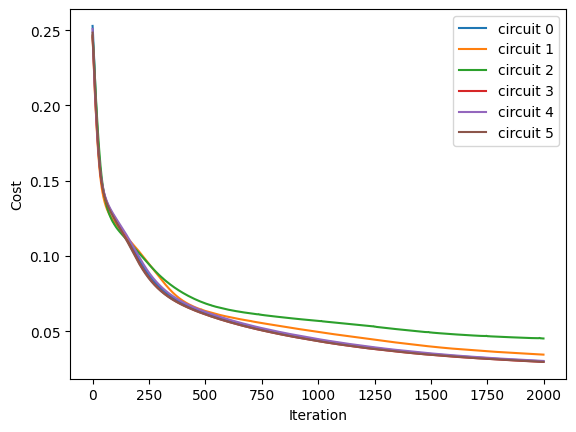

In [20]:
# use vvag to get the losses and gradients with different random circuit instances
QAOA_vvag = K.jit(K.vvag(QAOAansatz, argnums=0, vectorized_argnums=0), static_argnums=(1, 2, 3))

params_hard = K.implicit_randn(shape=[ncircuits, 2 * nlayers], stddev=0.1)  # initial parameters
if type(K).__name__ == 'JaxBackend':
    opt = K.optimizer(optax.adam(1e-2))
else:
    opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

list_of_loss = [[] for i in range(ncircuits)]

for i in range(2000):
    loss, grads = QAOA_vvag(params_hard, hard_graph)
    params_hard = opt.update(grads, params_hard)  # gradient descent

    # visualise the progress
    clear_output(wait=True)
    list_of_loss = np.hstack((list_of_loss, K.numpy(loss)[:, np.newaxis]))
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    for index in range(ncircuits):
        plt.plot(range(i + 1), list_of_loss[index])
    legend = [f'circuit {leg}' for leg in range(ncircuits)]
    plt.legend(legend)
    plt.show()

In [21]:
# print QAOA results
for num_circuit in range(ncircuits):
    print(f'Circuit #{num_circuit}')
    c = QAOAansatz(params=params_hard[num_circuit], g=hard_graph, return_circuit=True)
    loss = QAOAansatz(params=params_hard[num_circuit], g=hard_graph)

    # find the states with max probabilities
    probs = K.numpy(c.probability())
    max_prob = max(probs)
    index = np.where(probs == max_prob)[0]
    states = []
    for i in index:
        states.append(f'{bin(i)[2:]:0>{c._nqubits}}')
    print(f'cost: {K.numpy(loss)}\nmax prob: {max_prob}\nbit strings: {states}\n')

Circuit #0
cost: 0.02998761646449566
max prob: 0.04241819679737091
bit strings: ['111111000000']

Circuit #1
cost: 0.034460458904504776
max prob: 0.03702807426452637
bit strings: ['000000111111']

Circuit #2
cost: 0.04517427086830139
max prob: 0.027316443622112274
bit strings: ['111111000000']

Circuit #3
cost: 0.02961093559861183
max prob: 0.04281751438975334
bit strings: ['111111000000']

Circuit #4
cost: 0.030255526304244995
max prob: 0.042135994881391525
bit strings: ['111111000000']

Circuit #5
cost: 0.029639022424817085
max prob: 0.04278436675667763
bit strings: ['000000111111']



The probability of QAOA getting the correct solution is also very low. A very simple trick can be adopted to improve the performance of QAOA, namely quantum dropout, please refer to [following tutorials](qaoa_quantum_dropout.ipynb) or [Wang, Zheng, Wu, and Zhang (2023)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.023171).

In [22]:
tc.about()

OS info: Linux-5.4.119-1-tlinux4-0010.2-x86_64-with-glibc2.28
Python version: 3.10.11
Numpy version: 1.23.5
Scipy version: 1.11.0
Pandas version: 2.0.2
TensorNetwork version: 0.4.6
Cotengra is not installed
TensorFlow version: 2.12.0
TensorFlow GPU: []
TensorFlow CUDA infos: {'cpu_compiler': '/dt9/usr/bin/gcc', 'cuda_compute_capabilities': ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80'], 'cuda_version': '11.8', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True}
Jax version: 0.4.13
Jax installation doesn't support GPU
JaxLib version: 0.4.13
PyTorch version: 2.0.1
PyTorch GPU support: False
PyTorch GPUs: []
Cupy is not installed
Qiskit version: 0.24.1
Cirq version: 1.1.0
TensorCircuit version 0.10.0
